<a href="https://colab.research.google.com/github/RaedAbdelkefi/Reinforcement-learning-project-/blob/main/stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
from gymnasium import Env
from gymnasium import spaces


In [ ]:
stock='GOOGL'
start_date = '2020-01-01'
end_date = '2022-12-31'

#download prices data
data = yf.download(stock, start=start_date, end=end_date)

# Keep only the 'Close' prices for each stock
prices = data['Close']

# Calculate daily returns for each stock
returns = prices.pct_change()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
def data_processing(returns):
    df=returns.copy()
    df = pd.DataFrame(df)
    df.reset_index(inplace=True)
    df.drop(columns=['Date'], inplace=True)
    if df.isna().sum()[0]==1:
        df.drop(df.index[0], inplace=True)
    elif df.isna().sum()!=0:
        print('must looking t null values')
    return df



In [ ]:
df=data_processing(returns)

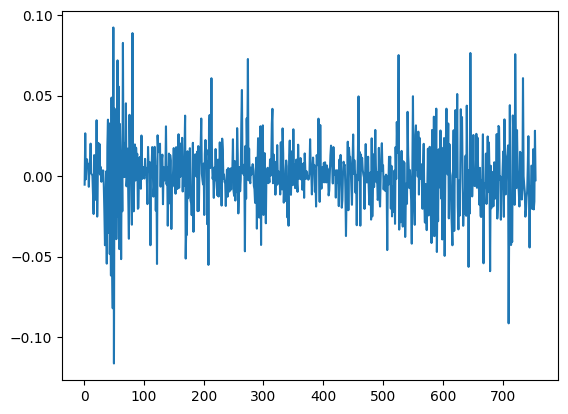

In [ ]:
plt.plot(df.index,df['Close'])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have your data in X
# Replace this with your actual data

# Splitting X into X_train and X_test
X_train, X_test = train_test_split(df, test_size=0.2,shuffle=False)

# Creating DataFrames for X_train and X_test
df_train = pd.DataFrame(X_train, columns=df.columns)  # Assuming X has column names
df_test = pd.DataFrame(X_test, columns=df.columns)    # Assuming X has column names

# Now X_train_df and X_test_df are your DataFrames for training and testing


In [ ]:
class Stock_Market(Env):
    def __init__(self,data,n):
        super(Stock_Market, self).__init__()
        self.n=n
        self.observation_space=spaces.Box(0,1,shape=(n-1,),dtype=np.float64)
        self.action_space=spaces.Discrete(3)
        self.state=[]
        self.profit=0
        self.buy_time=[]
        self.buy_prices=[]
        self.sell_time=[]
        self.sell_prices=[]
        self.data=data
        self.inventory=[]
        self.t=0
        self.last=self.data.index[-1]
        self.info={}

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def get(self,t,tf):
        return self.data[t:tf+1]['Close'].tolist()

    def get_state(self,t):
        self.state=[]
        time=t-self.n +1
        if time >= 0:
            batch=self.get(time,t)
        else:
            batch=-time*self.get(0,0)+self.get(0,t)
        for i in range(len(batch)-1):
            self.state.append(self.sigmoid(batch[i]-batch[i+1]))
        return self.state

    def step(self,action):
        reward=0
        done=False
        if action==1: #buy
            self.buy_time.append(self.t)
            self.buy_prices.append(self.get(self.t,self.t)[0])
            self.inventory.append(self.get(self.t,self.t)[0])
        if action ==2 and len(self.inventory)>0:#sell
            self.sell_time.append(self.t)
            bought_price=self.inventory.pop(0)
            reward=max(self.get(self.t,self.t)[0] - bought_price,0)
            self.profit+=self.get(self.t,self.t)[0]- bought_price
            self.sell_prices.append(self.get(self.t,self.t)[0])
        self.t+=1
        self.info={}

        if self.t==self.last-1:
            done=True
            next_state=self.get_state(0)
        else:
            next_state=self.get_state(self.t + 1)
        next_state=np.array(next_state)

        return next_state,  reward, done,False,self.info
    def reset(self,seed=None):
        np.random.seed(seed)
        self.state=self.get_state(0)
        self.state=np.array(self.state)
        self.profit=0
        self.buy_time=[]
        self.buy_prices=[]
        self.sell_time=[]
        self.sell_prices=[]
        self.t=0
        self.inventory=[]
        self.info={}
        return self.state,self.info



In [ ]:
from stable_baselines3.common.env_checker import check_env
env = Stock_Market(df_train,5)
check_env(env)

In [ ]:
from stable_baselines3 import DQN
import os
from stable_baselines3.common.vec_env import DummyVecEnv




models_dir = "stock"

# env = DummyVecEnv([lambda: env])

model = DQN('MlpPolicy', env, verbose=1)

TIMESTEPS = 100_000
iters = 0
model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 603      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3149     |
|    time_elapsed     | 0        |
|    total_timesteps  | 2412     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 603      |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.542    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3105     |
|    time_elapsed     | 1        |
|    total_timesteps  | 4824     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 603      |
|    ep_rew_mean      | 1.98  

In [ ]:
state,a=env.reset()
done=False
while not done:
    print('state :',state)
    print('length: ',state.shape)
    action=np.random.choice([0, 1, 2])
    print(action)
    next_state,reward,done,_,_=env.step(0)
    state=next_state

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, env, n_eval_episodes=10)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(0.0, 0.0)

In [ ]:
env.profit

0